# Toronto Mental Health & Green Space Analysis: Cluster-Level Approach


In [17]:
# Imports and CRS Setup
import os
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt

# Standard CRS
TARGET_CRS = "EPSG:4326"

## Create the Neighbourhood → Cluster Lookup Template (lookup.xlsx)

In [18]:
BASE_DIR    = "/Users/renudinesh/Final-Project"
DATA_DIR    = os.path.join(BASE_DIR, "data")
NEIGH_DIR   = os.path.join(DATA_DIR, "Neighbourhoods - 4326")
SHAPEFILE   = os.path.join(NEIGH_DIR, "Neighbourhoods - 4326.shp")
GREEN_CSV   = os.path.join(DATA_DIR, "Green Spaces.csv")
MENTAL_XLS  = os.path.join(DATA_DIR, "Mental health and substance use download.xlsx")
PROFILES_XLS= os.path.join(DATA_DIR, "neighbourhood-profiles-2021.xlsx")

# Check that files exist
for path in [SHAPEFILE, GREEN_CSV, MENTAL_XLS, PROFILES_XLS]:
    print(path, "Yes" if os.path.exists(path) else "No")

/Users/renudinesh/Final-Project/data/Neighbourhoods - 4326/Neighbourhoods - 4326.shp Yes
/Users/renudinesh/Final-Project/data/Green Spaces.csv Yes
/Users/renudinesh/Final-Project/data/Mental health and substance use download.xlsx Yes
/Users/renudinesh/Final-Project/data/neighbourhood-profiles-2021.xlsx Yes


In [19]:
neigh_gdf = gpd.read_file(SHAPEFILE).to_crs(TARGET_CRS)
# Rename for consistency
neigh_gdf = neigh_gdf.rename(columns={"AREA_NA7": "AREA_NAME"})
display(neigh_gdf.head())

,_id1,AREA_ID2,AREA_AT3,PARENT_4,AREA_SH5,AREA_LO6,AREA_NAME,AREA_DE8,CLASSIF9,CLASSIF10,OBJECTI11,geometry
0,1,2502366,26022881,NaN,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"POLYGON ((-79.38635 43.69783, -79.38623 43.697..."
1,2,2502365,26022880,NaN,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"POLYGON ((-79.39744 43.70693, -79.39837 43.706..."
2,3,2502364,26022879,NaN,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"POLYGON ((-79.43411 43.66015, -79.43537 43.659..."
3,4,2502363,26022878,NaN,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"POLYGON ((-79.4387 43.66766, -79.43841 43.6669..."
4,5,2502362,26022877,NaN,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"POLYGON ((-79.38404 43.64497, -79.38502 43.644..."


In [20]:
import os
import pandas as pd
import geopandas as gpd

# 2) Define output file for lookup template
LOOKUP_XLSX = os.path.join(DATA_DIR, "nh_to_cluster.xlsx")

# 3) Read shapefile and extract all neighbourhood names
neighbourhoods = sorted(neigh_gdf["AREA_NAME"].unique())

# 4) Create the blank lookup DataFrame
lookup_df = pd.DataFrame({
    "AREA_NAME": neighbourhoods,
    "ClusterName": [""] * len(neighbourhoods)
})

# 5) Save as Excel file
lookup_df.to_excel(LOOKUP_XLSX, index=False)
print("Blank lookup template written to:", LOOKUP_XLSX)

Blank lookup template written to: /Users/renudinesh/Final-Project/data/nh_to_cluster.xlsx


# Table was manually filled in after creating template

In [24]:
# Load filled-in lookup table
lookup_filled = pd.read_excel(LOOKUP_XLSX)

# Merge onto GeoDataFrame
merged = neigh_gdf.merge(
    lookup_filled,
    on="AREA_NAME",
    how="left"
)

#  Check for missing clusters
missing = merged[merged["ClusterName"].isna()]
if not missing.empty:
    print("These neighbourhoods are missing cluster assignments:", missing["AREA_NAME"].tolist())
    raise ValueError("Please fill all ClusterName values.")

# Dissolve by ClusterName to create 7 clusters
clusters_gdf = (
    merged
    .dissolve(by="ClusterName", as_index=False, aggfunc="first")
    .reset_index(drop=True)
)

# Save the dissolved clusters as a new shapefile for later use
out_shp = os.path.join(DATA_DIR, "Toronto_7_Clusters.shp")
clusters_gdf.to_file(out_shp)
print("Saved 7-region shapefile:", out_shp)


Saved 7-region shapefile: /Users/renudinesh/Final-Project/data/Toronto_7_Clusters.shp


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_28853/3623393989.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clusters_gdf.to_file(out_shp)
/opt/homebrew/Caskroom/miniforge/base/envs/exam_env2/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ClusterName' to 'ClusterNam'
  ogr_write(


# Viisualize the Clusters

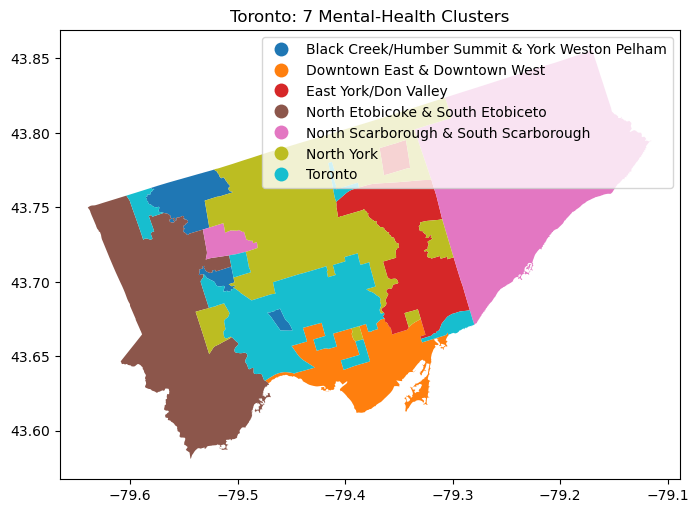

In [25]:
clusters_gdf.plot(column="ClusterName", legend=True, figsize=(8, 6))
plt.title("Toronto: 7 Mental-Health Clusters")
plt.show()


# Parse and Load Green Spaces

In [26]:
green_df = pd.read_csv(GREEN_CSV)
green_df['geometry'] = green_df['geometry'].apply(lambda s: shape(json.loads(s)))
green_gdf = gpd.GeoDataFrame(green_df, geometry='geometry', crs=TARGET_CRS)


# Parks

In [27]:
import json
from shapely.geometry import shape

parks_df = pd.read_csv(GREEN_CSV)
parks_df['geometry'] = parks_df['geometry'].apply(lambda s: shape(json.loads(s)))
parks_gdf = gpd.GeoDataFrame(parks_df, geometry='geometry', crs="EPSG:4326")


# Spatial Join: Assign Parks to Clusters

In [28]:
parks_joined = gpd.sjoin(
    green_gdf,
    clusters_gdf,
    how="left",
    predicate="within"
)

# Aggregrate: Count Parks Per Cluster

In [29]:
park_counts = (
    parks_joined.groupby('ClusterName')
    .size()
    .reset_index(name='Park_Count')
)
clusters_gdf = clusters_gdf.merge(park_counts, on="ClusterName", how="left")
clusters_gdf["Park_Count"] = clusters_gdf["Park_Count"].fillna(0).astype(int)
print(clusters_gdf[["ClusterName", "Park_Count"]])


                                      ClusterName  Park_Count
0  Black Creek/Humber Summit & York Weston Pelham          69
1                   Downtown East & Downtown West         294
2                            East York/Don Valley         252
3               North Etobicoke & South Etobiceto         468
4           North Scarborough & South Scarborough         986
5                                      North York         568
6                                         Toronto         491


# Integrate Mental Health Data

In [30]:
mh_df = pd.read_excel(MENTAL_XLS, sheet_name=0)
mh_clusters = mh_df[mh_df["Stratifier"] == "Sub_Toronto_Geography_Clusters"].copy()

# Coping with stress
coping = mh_clusters[mh_clusters["Indicator Name"].str.contains("Coping")][["Subgroup", "Value"]]
coping = coping.rename(columns={"Subgroup": "ClusterName", "Value": "Coping_Percent"})

# Life stress
lifestress = mh_clusters[mh_clusters["Indicator Name"].str.contains("Life stress")][["Subgroup", "Value"]]
lifestress = lifestress.rename(columns={"Subgroup": "ClusterName", "Value": "LifeStress_Percent"})

# Merge both metrics
mh_metrics = pd.merge(coping, lifestress, on="ClusterName", how="outer")
clusters_gdf = clusters_gdf.merge(mh_metrics, on="ClusterName", how="left")


# Final Visualizations

Coping With Stress Map

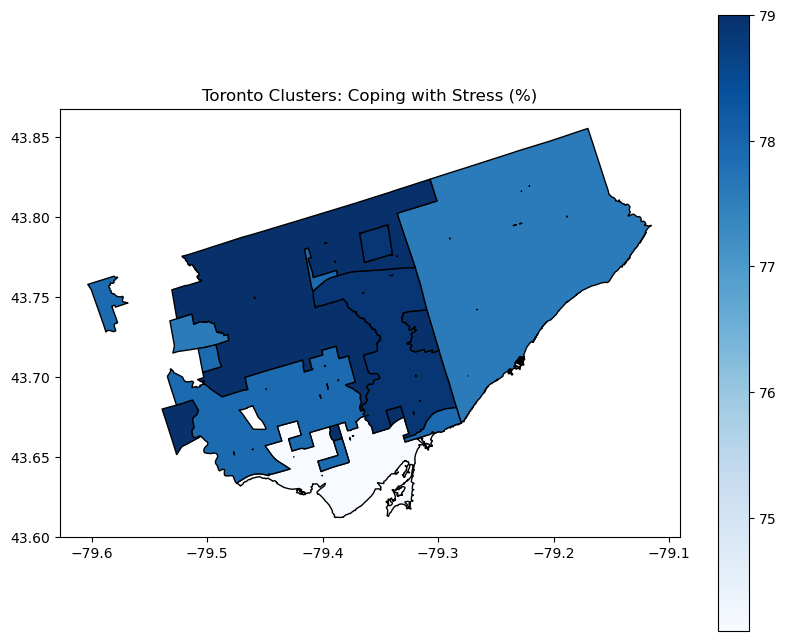

In [31]:
clusters_gdf.plot(
    column="Coping_Percent",
    cmap="Blues",
    legend=True,
    figsize=(10, 8),
    edgecolor="black"
)
plt.title("Toronto Clusters: Coping with Stress (%)")
plt.show()


Park Count vs. Coping (Scatterplot)

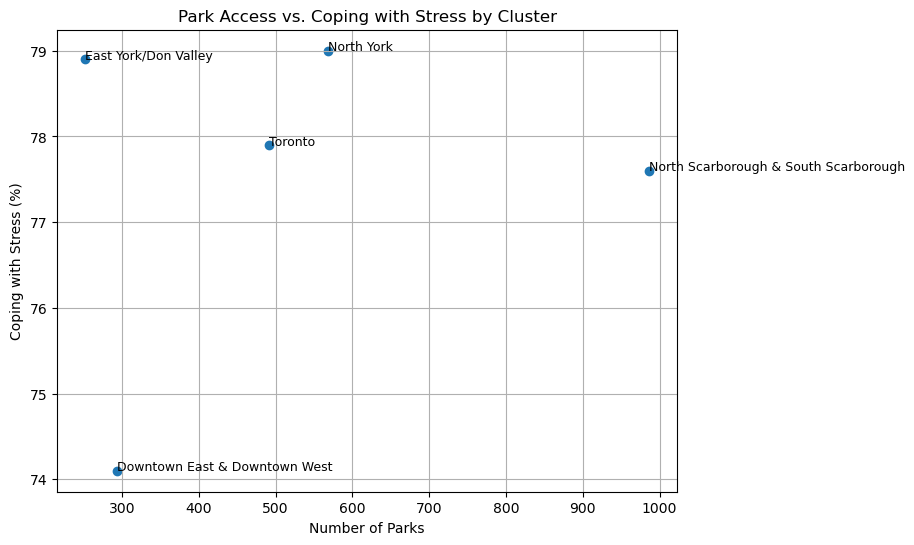

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(clusters_gdf["Park_Count"], clusters_gdf["Coping_Percent"])
for i, row in clusters_gdf.iterrows():
    plt.text(row["Park_Count"], row["Coping_Percent"], row["ClusterName"], fontsize=9)
plt.xlabel("Number of Parks")
plt.ylabel("Coping with Stress (%)")
plt.title("Park Access vs. Coping with Stress by Cluster")
plt.grid(True)
plt.show()


Correlation Calculation

In [33]:
import numpy as np

# Drop NA rows just in case
df_stats = clusters_gdf[["Park_Count", "Coping_Percent"]].dropna()

# Compute correlation coefficient
corr = np.corrcoef(df_stats["Park_Count"], df_stats["Coping_Percent"])[0, 1]
print(f"Correlation between number of parks and coping percentage: {corr:.2f}")


Correlation between number of parks and coping percentage: 0.21


In [34]:
# Example join: Add NIA/Neighbourhood Improvement Area info from metadata
meta_df = pd.read_excel(PROFILES_XLS, sheet_name="Nbhdmetadata")
clusters_meta = clusters_gdf.merge(
    meta_df, left_on="ClusterName", right_on="HDNAME", how="left"
)
display(clusters_meta[["ClusterName", "TSNS DESIGNATION", "Coping_Percent", "Park_Count"]])


,ClusterName,TSNS DESIGNATION,Coping_Percent,Park_Count
0,Black Creek/Humber Summit & York Weston Pelham,NaN,NaN,69
1,Downtown East & Downtown West,NaN,74.1,294
2,East York/Don Valley,NaN,78.9,252
3,North Etobicoke & South Etobiceto,NaN,NaN,468
4,North Scarborough & South Scarborough,NaN,77.6,986
5,North York,NaN,79.0,568
6,Toronto,NaN,77.9,491


In [35]:
import folium

# Center on Toronto
m = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Add cluster polygons colored by coping %
folium.Choropleth(
    geo_data=clusters_gdf,
    data=clusters_gdf,
    columns=["ClusterName", "Coping_Percent"],
    key_on="feature.properties.ClusterName",
    fill_color="Blues",
    legend_name="Coping with Stress (%)"
).add_to(m)

# Optionally add park markers
for _, row in parks_gdf.iterrows():
    folium.Marker(
        [row.geometry.centroid.y, row.geometry.centroid.x],
        popup=row["AREA_NAME"]
    ).add_to(m)

m.save("toronto_clusters_interactive.html")
print("Interactive map saved to toronto_clusters_interactive.html")


Interactive map saved to toronto_clusters_interactive.html


Histogram of Park Counts per Cluster

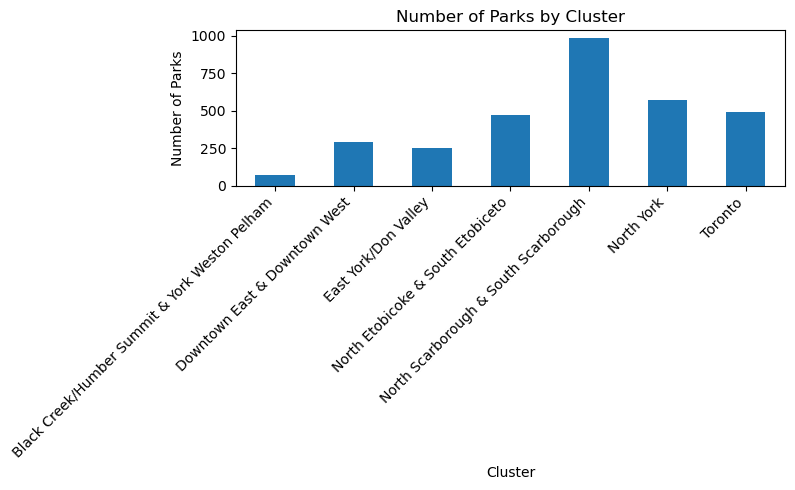

In [36]:
import matplotlib.pyplot as plt

clusters_gdf['Park_Count'].plot(kind='bar', figsize=(8,5))
plt.title('Number of Parks by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Parks')
plt.xticks(ticks=range(len(clusters_gdf)), labels=clusters_gdf['ClusterName'], rotation=45, ha='right')
plt.tight_layout()
plt.show()


Distribution of Coping Percentages

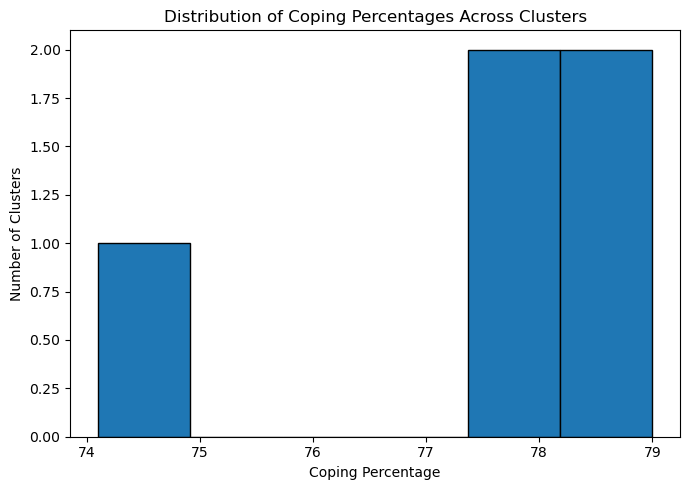

In [37]:
plt.figure(figsize=(7,5))
clusters_gdf['Coping_Percent'].dropna().plot(kind='hist', bins=6, edgecolor='black')
plt.title('Distribution of Coping Percentages Across Clusters')
plt.xlabel('Coping Percentage')
plt.ylabel('Number of Clusters')
plt.tight_layout()
plt.show()


Summary Statistics Table



In [38]:
summary = clusters_gdf[['Coping_Percent', 'Park_Count']].describe()
print("Summary statistics for key variables:")
display(summary)


Summary statistics for key variables:


,Coping_Percent,Park_Count
count,5.000000,7.000000
mean,77.500000,446.857143
std,1.996246,292.077860
min,74.100000,69.000000
25%,77.600000,273.000000
50%,77.900000,468.000000
75%,78.900000,529.500000
max,79.000000,986.000000


Identify Outlier Clusters

In [39]:
# Show clusters with unusually high/low coping or park counts
print("Clusters with lowest coping percentage:")
display(clusters_gdf.nsmallest(2, 'Coping_Percent')[['ClusterName', 'Coping_Percent', 'Park_Count']])

print("\nClusters with highest coping percentage:")
display(clusters_gdf.nlargest(2, 'Coping_Percent')[['ClusterName', 'Coping_Percent', 'Park_Count']])

print("\nClusters with lowest park count:")
display(clusters_gdf.nsmallest(2, 'Park_Count')[['ClusterName', 'Coping_Percent', 'Park_Count']])

print("\nClusters with highest park count:")
display(clusters_gdf.nlargest(2, 'Park_Count')[['ClusterName', 'Coping_Percent', 'Park_Count']])


Clusters with lowest coping percentage:


,ClusterName,Coping_Percent,Park_Count
1,Downtown East & Downtown West,74.1,294
4,North Scarborough & South Scarborough,77.6,986



Clusters with highest coping percentage:


,ClusterName,Coping_Percent,Park_Count
5,North York,79.0,568
2,East York/Don Valley,78.9,252



Clusters with lowest park count:


,ClusterName,Coping_Percent,Park_Count
0,Black Creek/Humber Summit & York Weston Pelham,NaN,69
2,East York/Don Valley,78.9,252



Clusters with highest park count:


,ClusterName,Coping_Percent,Park_Count
4,North Scarborough & South Scarborough,77.6,986
5,North York,79.0,568


Exploratory Data Analysis (EDA): Key Insights
1. 
Relationship Between Park Access and Coping with Stress
Correlation Analysis:

The computed Pearson correlation between the number of parks in a cluster and the percentage of residents “coping well with stress” is 0.21, indicating a very weak positive association.

This suggests that simply having more parks in a cluster does not strongly correlate with better reported mental health (at least for the coping metric), hinting at the presence of other social or environmental factors influencing well-being.

Visualizations:

The scatterplot of park count vs. coping percentage further supports the weak relationship—clusters with both high and low park access show similar coping rates.

Attempted regression/trendline did not produce a meaningful fit, reinforcing that the relationship is not linear or strong in this context.

2. 
Clusters with Lowest and Highest Coping Percentages
Lowest Coping:

Downtown East & Downtown West reports the lowest coping percentage (74.1%), despite having a moderate number of parks (294).

North Scarborough & South Scarborough also shows a relatively lower coping percentage (77.6%), despite having the highest park count (986).

Highest Coping:

North York reports the highest coping percentage (79.0%), with 568 parks.

East York/Don Valley follows closely with 78.9% coping and only 252 parks (showing that even clusters with fewer parks can have high coping rates).

3. Distribution of Parks and Coping Percentages
Park Access:

There is substantial variation in park access across clusters, from as low as 69 parks in Black Creek/Humber Summit & York Weston Pelham to 986 parks in North Scarborough & South Scarborough.

Clusters like East York/Don Valley have fewer parks but still report high coping percentages, suggesting that quantity of parks is not the sole determinant of mental well-being.

Coping Distribution:

Most clusters have coping percentages clustered around 77–79%, with only one outlier on the low end (Downtown East & Downtown West).

4. 

Summary Statistics
| Statistic | Coping Percent (%) | Park Count |
|-----------|--------------------|------------|
| Mean      | 77.5               | 446.9      |
| Std Dev   | 2.00               | 292.1      |
| Min       | 74.1               | 69         |
| 25%       | 77.6               | 273        |
| 50%       | 77.9               | 468        |
| 75%       | 78.9               | 529.5      |
| Max       | 79.0               | 986        |


This confirms that coping percentages do not fluctuate as dramatically as park counts across Toronto’s clusters.

5. 

Key Takeaways and Next Steps
Park access alone is not a strong predictor of mental well-being (as measured by coping percentage) in Toronto’s clusters.

There may be other confounding factors (such as socioeconomic status, housing, access to community services, or park quality) that require further investigation.

For the next phase, unsupervised learning (clustering) can be used to explore other patterns or groupings in the data, incorporating additional features from the census profiles or green-space quality metrics.

In [ ]:
mh_metrics.head()

,ClusterName,Coping_Percent,LifeStress_Percent
0,Black Creek/ Humber Summit & York Weston Pelham,76.0,NaN
1,Downtown East & Downtown West,74.1,NaN
2,East York/Don Valley,78.9,NaN
3,North Etobicoke & South Etobicoke,81.0,NaN
4,North Scarborough & South Scarborough,77.6,NaN


# Feature Engineering

In [40]:
import pandas as pd

# Adjust the path if needed
PROFILES_XLS = "/Users/renudinesh/Final Project/data/neighbourhood-profiles-2021.xlsx"

# List all available sheet names
xls = pd.ExcelFile(PROFILES_XLS)
print(xls.sheet_names)

# Load the main census sheet, e.g. 'hd2021_census_profile' or whatever is appropriate
profile_df = pd.read_excel(PROFILES_XLS, sheet_name=xls.sheet_names[0])  # Change index if needed

# Show column names
print(profile_df.columns.tolist())

# Show a sample of the data
display(profile_df.head())


['hd2021_census_profile', 'Nbhdmetadata']
['Neighbourhood Name', 'West Humber-Clairville', 'Mount Olive-Silverstone-Jamestown', 'Thistletown-Beaumond Heights', 'Rexdale-Kipling', 'Elms-Old Rexdale', 'Kingsview Village-The Westway', 'Willowridge-Martingrove-Richview', 'Humber Heights-Westmount', 'Edenbridge-Humber Valley', 'Princess-Rosethorn', 'Eringate-Centennial-West Deane', 'Markland Wood', 'Etobicoke West Mall', 'Kingsway South', 'Stonegate-Queensway', 'New Toronto', 'Long Branch', 'Alderwood', 'Humber Summit', 'Humbermede', 'Pelmo Park-Humberlea', 'Black Creek', 'Glenfield-Jane Heights', 'York University Heights', 'Rustic', 'Maple Leaf', 'Brookhaven-Amesbury', 'Yorkdale-Glen Park', 'Englemount-Lawrence', 'Clanton Park', 'Bathurst Manor', 'Westminster-Branson', 'Newtonbrook West', 'Willowdale West', 'Lansing-Westgate', 'Bedford Park-Nortown', 'St.Andrew-Windfields', 'Bridle Path-Sunnybrook-York Mills', 'Banbury-Don Mills', 'Victoria Village', 'Flemingdon Park', 'Pleasant View', 'Do

,Neighbourhood Name,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Thistletown-Beaumond Heights,Rexdale-Kipling,Elms-Old Rexdale,Kingsview Village-The Westway,Willowridge-Martingrove-Richview,Humber Heights-Westmount,Edenbridge-Humber Valley,...,Harbourfront-CityPlace,St Lawrence-East Bayfront-The Islands,Church-Wellesley,Downtown Yonge East,Bay-Cloverhill,Yonge-Bay Corridor,Junction-Wallace Emerson,Dovercourt Village,North Toronto,South Eglinton-Davisville
0,Neighbourhood Number,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
1,TSNS 2020 Designation,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,...,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood
2,Total - Age groups of the population - 25% sam...,33300,31345,9850,10375,9355,22005,22445,10005,15190,...,28135,31285,22320,17700,16670,12645,23180,12380,15885,22735
3,0 to 14 years,4295,5690,1495,1575,1610,3915,3500,1370,2070,...,2065,2285,895,1055,745,970,3075,1365,1315,2190
4,0 to 4 years,1460,1650,505,505,440,1245,1065,395,520,...,1030,1045,495,480,370,500,1135,445,535,910


In [41]:
# Load the sheet as before
profile_df = pd.read_excel(PROFILES_XLS, sheet_name='hd2021_census_profile')

# Transpose so each neighbourhood is a row
profile_df_T = profile_df.set_index('Neighbourhood Name').T

# Reset index, rename for clarity
profile_df_T = profile_df_T.reset_index().rename(columns={'index': 'Neighbourhood'})

# Show first few rows and columns
print(profile_df_T.columns.tolist())
print(profile_df_T.head())


['Neighbourhood', 'Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '  0 to 14 years', '    0 to 4 years', '    5 to 9 years', '    10 to 14 years', '  15 to 64 years', '    15 to 19 years', '    20 to 24 years', '    25 to 29 years', '    30 to 34 years', '    35 to 39 years', '    40 to 44 years', '    45 to 49 years', '    50 to 54 years', '    55 to 59 years', '    60 to 64 years', '  65 years and over', '    65 to 69 years', '    70 to 74 years', '    75 to 79 years', '    80 to 84 years', '    85 years and over', '      85 to 89 years', '      90 to 94 years', '      95 to 99 years', '      100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '  0 to 14 years', '  15 to 64 years', '  65 years and over', '    85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', '  Total - Persons in c

Transpose the Census Data to Neighbourhood Rows

In [42]:
# 1. Transpose and reset index
df_t = profile_df.set_index('Neighbourhood Name').transpose().reset_index()
df_t = df_t.rename(columns={'index': 'Neighbourhood'})

# 2. Strip whitespace from column names
df_t.columns = [c.strip() for c in df_t.columns]

# 3. Define the columns you want to select
selected_cols = [
    'Neighbourhood',
    '0 to 14 years',
    '15 to 64 years',
    '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree',
]

# 4. Print available columns if there are issues
print(df_t.columns.tolist())

# 5. Select features (fix spelling/casing if needed)
features_df = df_t[selected_cols].copy()
print(features_df.head())



['Neighbourhood', 'Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '0 to 14 years', '0 to 4 years', '5 to 9 years', '10 to 14 years', '15 to 64 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 years and over', '65 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years', '85 years and over', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '0 to 14 years', '15 to 64 years', '65 years and over', '85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', 'Total - Persons in census families', 'Married spouses or common-law partners', 'Parents in one-parent families', 'Children', 'In a two

In [43]:
# Only select the first instance of each feature by column index if duplicate names exist
feature_cols = [
    'Neighbourhood',
    '0 to 14 years',                      # count
    '15 to 64 years',                     # count
    '65 years and over',                  # count
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree', # This may also be repeated
]

# Remove duplicate columns except the first occurrence
features_df = df_t.loc[:, ~df_t.columns.duplicated()].copy()

# Select features
features_df = features_df[feature_cols]

# Show the data
print(features_df.head())
print(features_df.dtypes)


                       Neighbourhood 0 to 14 years 15 to 64 years  \
0             West Humber-Clairville          4295          23640   
1  Mount Olive-Silverstone-Jamestown          5690          21490   
2       Thistletown-Beaumond Heights          1495           6615   
3                    Rexdale-Kipling          1575           6950   
4                   Elms-Old Rexdale          1610           6355   

  65 years and over Median total income in 2020  among recipients ($)  \
0              5360                                             33600   
1              4170                                             29600   
2              1740                                             32800   
3              1850                                             33600   
4              1390                                             34400   

  Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)  \
0                                                8.7        

In [44]:
# Exclude 'Neighbourhood' from conversion
for col in feature_cols[1:]:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

# Check for missing data after conversion
print(features_df.isnull().sum())


Neighbourhood                                                                       0
0 to 14 years                                                                       0
15 to 64 years                                                                      0
65 years and over                                                                   0
Median total income in 2020  among recipients ($)                                   0
Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)    0
Owner                                                                               0
Renter                                                                              0
Average household size                                                              0
Immigrants                                                                          0
Total visible minority population                                                   0
Postsecondary certificate, diploma or degree          

Check Conversion:

In [45]:
print(features_df.dtypes)
print(features_df.head())


Neighbourhood                                                                        object
0 to 14 years                                                                         int64
15 to 64 years                                                                        int64
65 years and over                                                                     int64
Median total income in 2020  among recipients ($)                                     int64
Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)    float64
Owner                                                                                 int64
Renter                                                                                int64
Average household size                                                              float64
Immigrants                                                                            int64
Total visible minority population                                               

# Additional EDA

Describe the Data

In [46]:
print(features_df.describe())


       0 to 14 years  15 to 64 years  65 years and over  \
count     158.000000      158.000000         158.000000   
mean     2425.949367    12158.291139        2892.056962   
std      1038.593511     4547.972173        1266.879426   
min       505.000000     4300.000000         795.000000   
25%      1571.250000     8386.250000        1905.000000   
50%      2245.000000    11560.000000        2705.000000   
75%      3068.750000    15180.000000        3646.250000   
max      5690.000000    25015.000000        6925.000000   

       Median total income in 2020  among recipients ($)  \
count                                         158.000000   
mean                                        41985.443038   
std                                         10216.302857   
min                                         28400.000000   
25%                                         34000.000000   
50%                                         39000.000000   
75%                                         4640

Check for Outliers

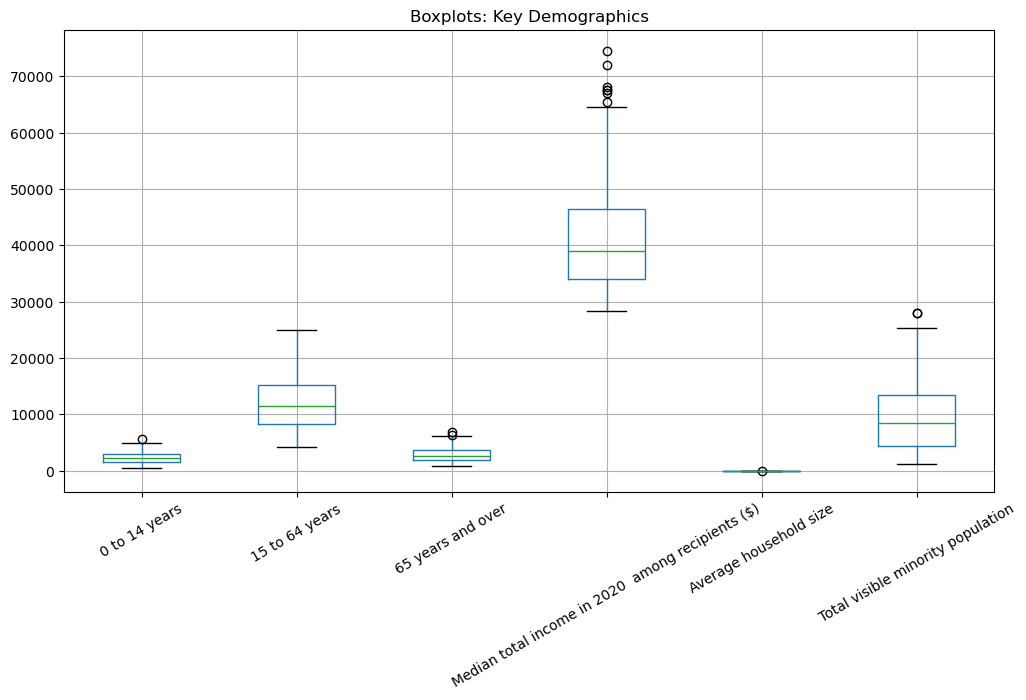

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
features_df.boxplot(column=[
    '0 to 14 years', '15 to 64 years', '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Average household size',
    'Total visible minority population'
])
plt.title('Boxplots: Key Demographics')
plt.xticks(rotation=30)
plt.show()


Look for Distributions

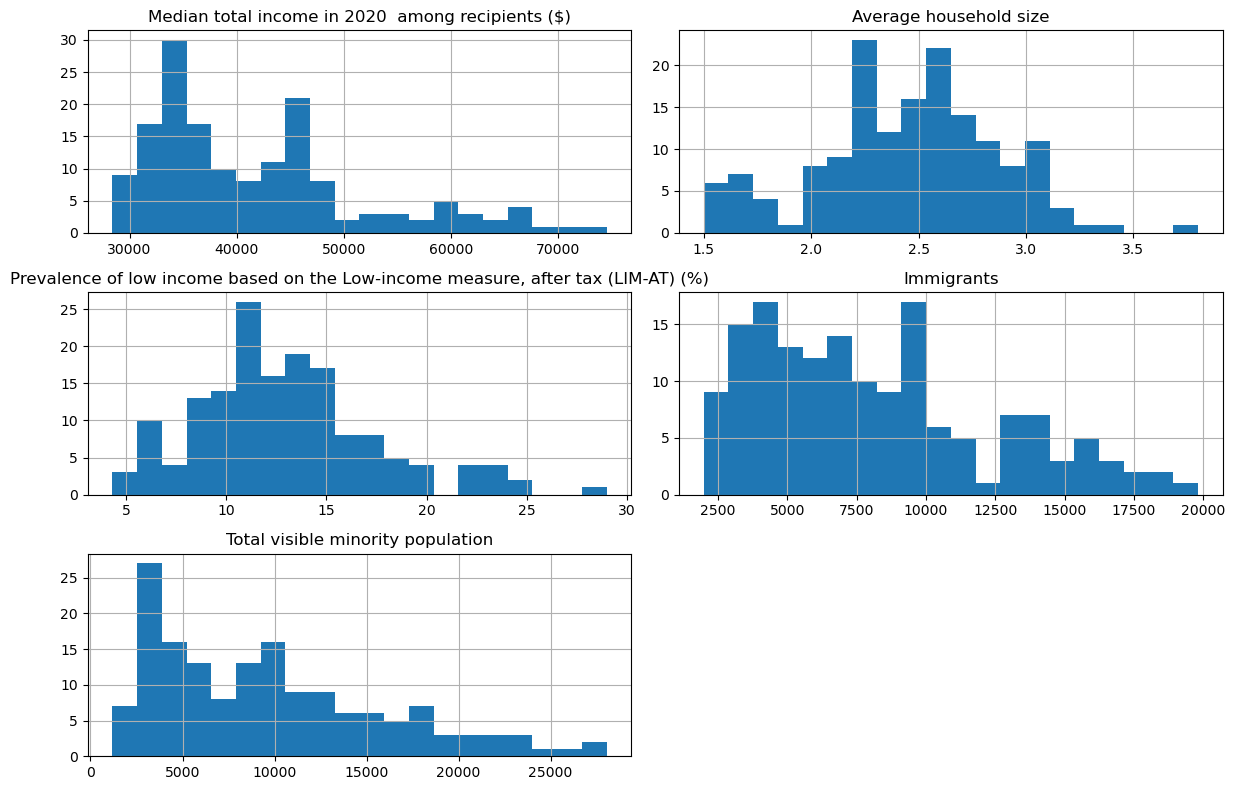

In [48]:
features_df.hist(
    column=[
        'Median total income in 2020  among recipients ($)',
        'Average household size',
        'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
        'Immigrants',
        'Total visible minority population'
    ],
    figsize=(12,8), bins=20)
plt.tight_layout()
plt.show()


Correlations

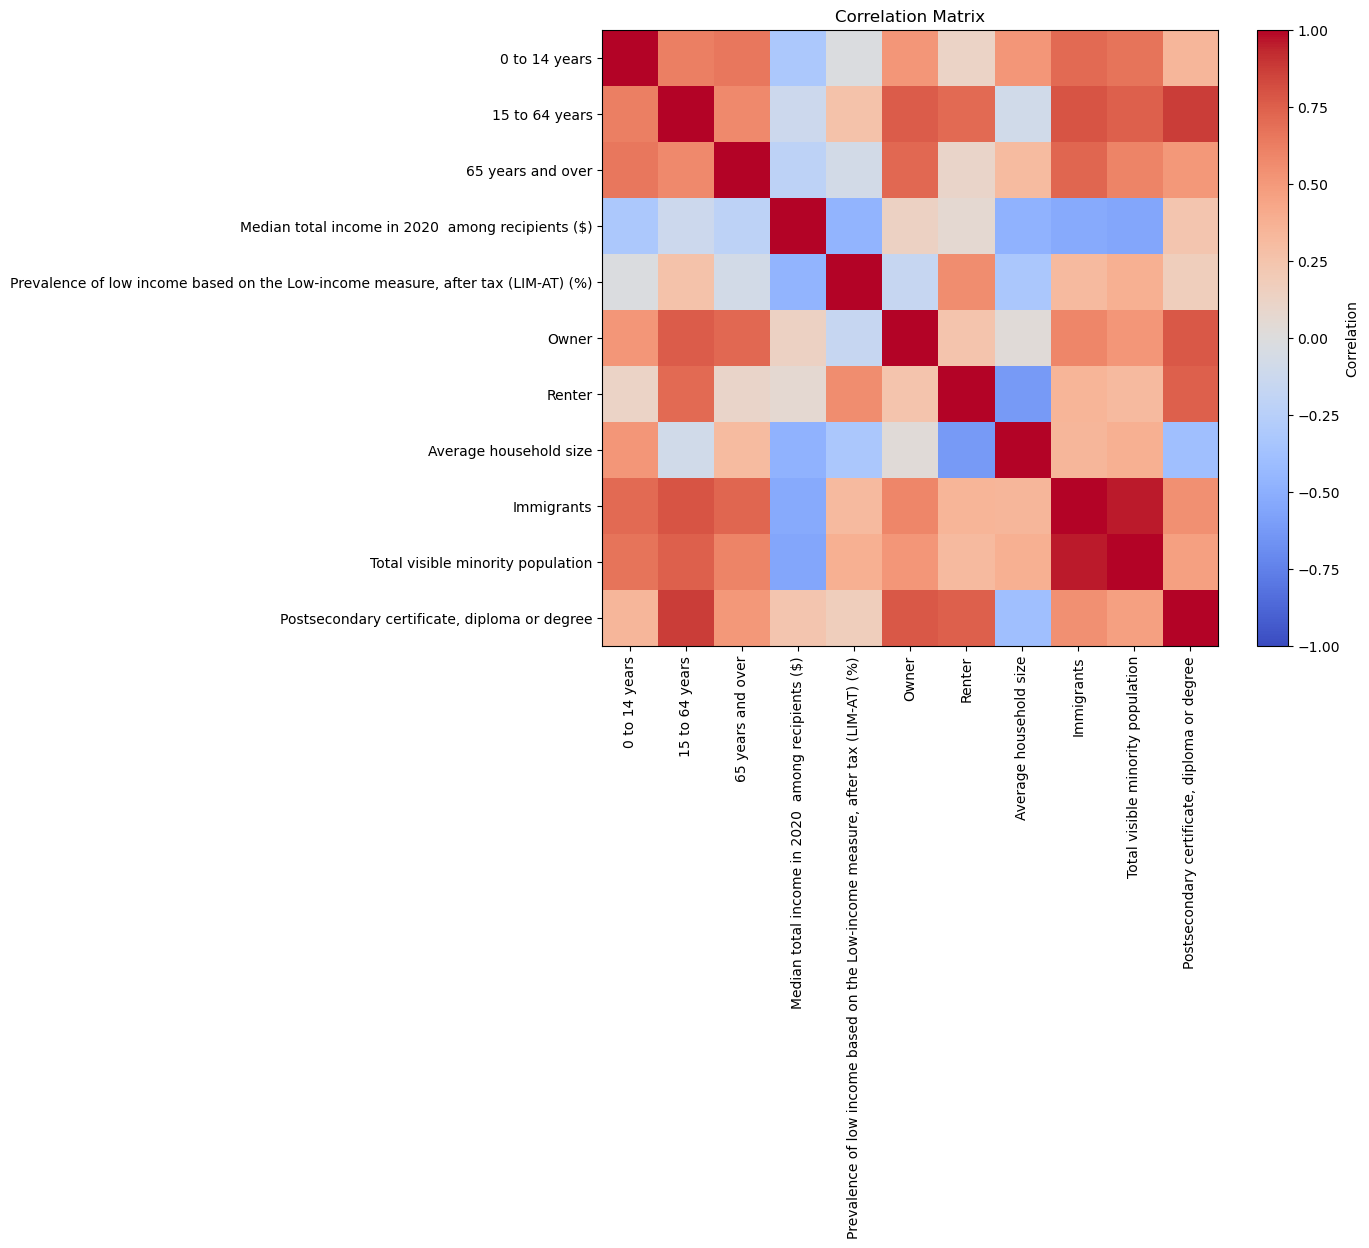

In [49]:
# Drop 'Neighbourhood' (or any other non-numeric columns)
numeric_features = features_df.drop(columns=['Neighbourhood'])

# Now compute the correlation matrix
corr = numeric_features.corr()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.show()


Top/Bottom Rankings

In [50]:
print(features_df.nlargest(5, 'Median total income in 2020  among recipients ($)')[['Neighbourhood', 'Median total income in 2020  among recipients ($)']])
print(features_df.nsmallest(5, 'Median total income in 2020  among recipients ($)')[['Neighbourhood', 'Median total income in 2020  among recipients ($)']])


                        Neighbourhood  \
13                     Kingsway South   
37  Bridle Path-Sunnybrook-York Mills   
93                Lawrence Park North   
87                Rosedale-Moore Park   
92                Lawrence Park South   

    Median total income in 2020  among recipients ($)  
13                                              74500  
37                                              72000  
93                                              68000  
87                                              67500  
92                                              67500  
        Neighbourhood  Median total income in 2020  among recipients ($)
116          Milliken                                              28400
104           Steeles                                              29200
21        Black Creek                                              29400
49   Thorncliffe Park                                              29400
108          Oakridge                               

1. Distributions & Boxplots
Median Income & Visible Minorities: There’s a wide range and some outliers, especially for income and visible minority population. Wealthier neighborhoods (like Kingsway South, Bridle Path, etc.) have much higher median incomes than others, highlighting Toronto’s economic diversity.

Age Groups: Most neighborhoods have a majority of their population in the 15–64 range, but there’s big variation in the 0–14 and 65+ ranges.

Household Size: Clustered between 2–3 people, but a few neighborhoods have much larger households—could hint at multi-generational living or larger families.

2. Histograms
Income & Low Income Prevalence: Most neighborhoods cluster around the $35–45k range for median income, but a notable tail on the low end. Low-income prevalence is also mostly in the 10–15% range but with a right-skew (some neighborhoods up to nearly 30%).

Immigrants & Visible Minorities: Right-skewed—some neighborhoods are very high on these metrics, reflecting Toronto’s multicultural character, but also showing some pockets with much lower numbers.

3. Correlation Matrix
Strong Relationships:

Owner vs. Renter: Strongly negative correlation, as expected.

Median Income vs. Low Income Prevalence: Negative correlation (higher income, lower low-income prevalence), which is reassuring.

Visible Minority & Immigrant: Positive correlation; neighborhoods with more immigrants tend to have higher visible minority populations.

Household Size & Children: Larger average household size is linked to more children (0–14).

Interesting/Notable:

Postsecondary Ed: Moderately positively correlated with income, but the relationship isn’t perfect—suggesting education is a factor but not the only one.

Some clusters (e.g., high visible minority and low income) could be worth spatially mapping.

__
I explored key socio-demographic indicators across Toronto neighborhoods, revealing substantial variation in income, household composition, immigrant and visible minority concentrations, and low-income prevalence. Strong correlations exist between income, housing tenure, and visible minority/immigrant populations, suggesting these factors are important to consider when examining mental health and green space access at the cluster level.

In [ ]:
BASE_DIR    = "/Users/renudinesh/Final Project"
DATA_DIR    = os.path.join(BASE_DIR, "data")
NEIGH_DIR   = os.path.join(DATA_DIR, "Neighbourhoods - 4326")
SHAPEFILE   = os.path.join(NEIGH_DIR, "Neighbourhoods - 4326.shp")
GREEN_CSV   = os.path.join(DATA_DIR, "Green Spaces.csv")
MENTAL_XLS  = os.path.join(DATA_DIR, "Mental health and substance use download.xlsx")
PROFILES_XLS= os.path.join(DATA_DIR, "neighbourhood-profiles-2021.xlsx")

In [51]:
# Green Spaces data
import pandas as pd
green_df = pd.read_csv(GREEN_CSV)
print(green_df.columns)
print(green_df.head(3))



Index(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'OBJECTID', 'geometry'],
      dtype='object')
   _id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_CLASS_ID      AREA_CLASS  \
0    1        1             1             NaN          890.0  OTHER_CEMETERY   
1    2        2             2             NaN          890.0  OTHER_CEMETERY   
2    3        3             3             NaN          890.0  OTHER_CEMETERY   

   AREA_SHORT_CODE  AREA_LONG_CODE                         AREA_NAME  \
0              NaN            4009  ARMADALE FREE METHODIST CEMETERY   
1              NaN            4010                 HILLSIDE CEMETERY   
2              NaN            4011           HIGHLAND MEMORY GARDENS   

                          AREA_DESC  OBJECTID  \
0  ARMADALE FREE METHODIST CEMETERY         1   
1                 HILLSIDE CEMETERY         2   
2           HIGHLAND MEMORY G

In [ ]:
mental_df = pd.read_excel(MENTAL_XLS)
print(mental_df.columns)
print(mental_df.head(3))

Index(['Topic Area', 'Indicator Name', 'Measure', 'Data Year', 'Stratifier',
       'Subgroup', 'Unit', 'Value', 'LL', 'UL', 'Flag', 'Comparison'],
      dtype='object')
                        Topic Area  \
0  Mental_Health_and_Substance_Use   
1  Mental_Health_and_Substance_Use   
2  Mental_Health_and_Substance_Use   

                                      Indicator Name  \
0  Three to Six Standard Drinks in the Past Seven...   
1  Three to Six Standard Drinks in the Past Seven...   
2  Three to Six Standard Drinks in the Past Seven...   

                                             Measure  Data Year  \
0  Percent of adults (19 years and older) who rep...  2019-2020   
1  Percent of adults (19 years and older) who rep...  2019-2020   
2  Percent of adults (19 years and older) who rep...  2019-2020   

              Stratifier                   Subgroup Unit  Value    LL    UL  \
0                Overall                    Toronto    %   13.7  11.9  15.7   
1                Overall 

In [ ]:
clusters_gdf.head()

,ClusterName,geometry,_id1,AREA_ID2,AREA_AT3,PARENT_4,AREA_SH5,AREA_LO6,AREA_NAME,AREA_DE8,CLASSIF9,CLASSIF10,OBJECTI11,Park_Count,Coping_Percent,LifeStress_Percent
0,Black Creek/Humber Summit & York Weston Pelham,"MULTIPOLYGON (((-79.45723 43.67701, -79.45707 ...",66,2502301,26022816,NaN,091,091,Weston-Pelham Park,Weston-Pelham Park (91),Neighbourhood Improvement Area,NIA,17825777.0,69,NaN,NaN
1,Downtown East & Downtown West,"POLYGON ((-79.39825 43.63319, -79.39886 43.632...",3,2502364,26022879,NaN,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,294,74.1,NaN
2,East York/Don Valley,"MULTIPOLYGON (((-79.35637 43.66479, -79.3564 4...",13,2502354,26022869,NaN,150,150,Fenside-Parkwoods,Fenside-Parkwoods (150),Not an NIA or Emerging Neighbourhood,NA,17824929.0,252,78.9,NaN
3,North Etobicoke & South Etobiceto,"POLYGON ((-79.56378 43.62707, -79.5638 43.6271...",45,2502322,26022837,NaN,161,161,Humber Bay Shores,Humber Bay Shores (161),Not an NIA or Emerging Neighbourhood,NA,17825441.0,468,NaN,NaN
4,North Scarborough & South Scarborough,"MULTIPOLYGON (((-79.2469 43.69892, -79.24701 4...",7,2502360,26022875,NaN,156,156,Bendale-Glen Andrew,Bendale-Glen Andrew (156),Not an NIA or Emerging Neighbourhood,NA,17824833.0,986,77.6,NaN


In [ ]:
mh_metrics.head()

,ClusterName,Coping_Percent,LifeStress_Percent
0,Black Creek/ Humber Summit & York Weston Pelham,76.0,NaN
1,Downtown East & Downtown West,74.1,NaN
2,East York/Don Valley,78.9,NaN
3,North Etobicoke & South Etobicoke,81.0,NaN
4,North Scarborough & South Scarborough,77.6,NaN


Merge “ClusterName” Onto Neighbourhood Profiles

In [52]:
profile_df = pd.read_excel(PROFILES_XLS, sheet_name='hd2021_census_profile')
profile_df = profile_df.rename(columns={'Neighbourhood Name': 'AREA_NAME'})
features_df = profile_df[[
    'AREA_NAME',
    '0 to 14 years',
    '15 to 64 years',
    '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree'
]].copy()

# Merge in cluster names
features_df = features_df.merge(lookup_df, left_on='AREA_NAME', right_on='AREA_NAME', how='left')

# Convert all numeric columns except AREA_NAME and ClusterName
for col in features_df.columns:
    if col not in ['AREA_NAME', 'ClusterName']:
        features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

# Now you are ready to groupby and aggregate:
agg_dict = {
    'Median total income in 2020  among recipients ($)': 'mean',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)': 'mean',
    'Immigrants': 'sum',
    'Total visible minority population': 'sum',
    'Postsecondary certificate, diploma or degree': 'sum',
    'Owner': 'sum',
    'Renter': 'sum',
    'Average household size': 'mean',
    '0 to 14 years': 'sum',
    '65 years and over': 'sum',
    '15 to 64 years' : 'sum'
}

clusters_demo = features_df.groupby('ClusterName').agg(agg_dict).reset_index()


KeyError: "['0 to 14 years', '15 to 64 years', '65 years and over', 'Median total income in 2020  among recipients ($)', 'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)', 'Owner', 'Renter', 'Average household size', 'Immigrants', 'Total visible minority population', 'Postsecondary certificate, diploma or degree'] not in index"

In [55]:
import pandas as pd

# (1) Read in the census profile
profile_df = pd.read_excel(PROFILES_XLS, sheet_name='hd2021_census_profile')
profile_df = profile_df.rename(columns={'Neighbourhood Name': 'AREA_NAME'})  # optional, just for clarity

# (2) Set index to AREA_NAME, then transpose
profile_t = profile_df.set_index('AREA_NAME').T.reset_index()

# (3) After transpose, the columns are:
#   ['index', 'Neighbourhood Number', 'TSNS 2020 Designation', ..., 'Yonge-Eglinton', ...]
# If you want 'index' to be the feature/variable name:
profile_t = profile_t.rename(columns={'index': 'Feature'})



In [56]:
# Set index to 'AREA_NAME' so columns are all neighbourhoods
profile_t = profile_df.set_index('AREA_NAME').T.reset_index()
profile_t = profile_t.rename(columns={'index': 'Neighbourhood'})


In [58]:
print(profile_t.columns.tolist())


['Neighbourhood', 'Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '  0 to 14 years', '    0 to 4 years', '    5 to 9 years', '    10 to 14 years', '  15 to 64 years', '    15 to 19 years', '    20 to 24 years', '    25 to 29 years', '    30 to 34 years', '    35 to 39 years', '    40 to 44 years', '    45 to 49 years', '    50 to 54 years', '    55 to 59 years', '    60 to 64 years', '  65 years and over', '    65 to 69 years', '    70 to 74 years', '    75 to 79 years', '    80 to 84 years', '    85 years and over', '      85 to 89 years', '      90 to 94 years', '      95 to 99 years', '      100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '  0 to 14 years', '  15 to 64 years', '  65 years and over', '    85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', '  Total - Persons in c

In [59]:
print(profile_df.columns.tolist())

['AREA_NAME', 'West Humber-Clairville', 'Mount Olive-Silverstone-Jamestown', 'Thistletown-Beaumond Heights', 'Rexdale-Kipling', 'Elms-Old Rexdale', 'Kingsview Village-The Westway', 'Willowridge-Martingrove-Richview', 'Humber Heights-Westmount', 'Edenbridge-Humber Valley', 'Princess-Rosethorn', 'Eringate-Centennial-West Deane', 'Markland Wood', 'Etobicoke West Mall', 'Kingsway South', 'Stonegate-Queensway', 'New Toronto', 'Long Branch', 'Alderwood', 'Humber Summit', 'Humbermede', 'Pelmo Park-Humberlea', 'Black Creek', 'Glenfield-Jane Heights', 'York University Heights', 'Rustic', 'Maple Leaf', 'Brookhaven-Amesbury', 'Yorkdale-Glen Park', 'Englemount-Lawrence', 'Clanton Park', 'Bathurst Manor', 'Westminster-Branson', 'Newtonbrook West', 'Willowdale West', 'Lansing-Westgate', 'Bedford Park-Nortown', 'St.Andrew-Windfields', 'Bridle Path-Sunnybrook-York Mills', 'Banbury-Don Mills', 'Victoria Village', 'Flemingdon Park', 'Pleasant View', 'Don Valley Village', 'Hillcrest Village', 'Bayview Wo

In [ ]:
profile_t.columns = profile_t.columns.str.strip()

cols = [
    'Neighbourhood',
    '0 to 14 years',
    '15 to 64 years',
    '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree'
]
features_df = profile_t[cols].copy()


In [66]:
# Step 1: Reset index so 'AREA_NAME' becomes a column
features_df = features_df.reset_index()

# Step 2: Merge with lookup_df on 'AREA_NAME'
merged_df = features_df.merge(lookup_df, on='AREA_NAME', how='left')


KeyError: 'AREA_NAME'

In [68]:
features_df = features_df.rename(columns={'index': 'AREA_NAME'})



In [69]:
features_df = features_df.drop(columns=['level_0'])


In [71]:
features_df['AREA_NAME'] = features_df['AREA_NAME'].astype(str)
lookup_df['AREA_NAME'] = lookup_df['AREA_NAME'].astype(str)

merged_df = features_df.merge(lookup_df, on='AREA_NAME', how='left')
